<a href="https://colab.research.google.com/github/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/haripota_museum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 魔法世界の裏側は博物館？

1. 必要なライブラリーのインストール
1. TFIDFの作成とUMAPによる可視化
1. ロジスティック回帰による分類実験

In [1]:
# spaCyとginza, ja_ginzaモデルのインストール
! pip install -U spacy ginza ja_ginza
#　日本語の描画に必要
! pip install japanize-matplotlib
# 次元圧縮
! pip install umap-learn

  Using cached spacy-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
  Using cached weasel-0.3.3-py3-none-any.whl (49 kB)
  Using cached cloudpathlib-0.16.0-py3-none-any.whl (45 kB)


In [2]:
import pandas as pd
import requests
from io import BytesIO

# ファイルIDを使用してダウンロードURLを作成
file_id = "1a2fVSyTzHEDDyvGpQc5acNKCo-8O2iIe"
download_url = f"https://drive.google.com/uc?id={file_id}"

# ファイルをダウンロード
response = requests.get(download_url)
response.raise_for_status()

# BytesIOを使用して、直接pandasで読み込み
data = BytesIO(response.content)
# なお、このデータは以下のノートブックで作成している。
# https://github.com/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/haripota_data_prep.ipynb
df = pd.read_pickle(data)

In [3]:
# サンプリング後のデータをX, yに分ける
X = df['text'].tolist()
y = df['label'].tolist()

In [4]:
import spacy

nlp = spacy.load("ja_ginza")

def tokenize(text):
    return [token.text for token in nlp(text)]

# 単語(より厳密には形態素)に分割できる
tokenize("正気かどうかは統計上の問題ではない")

['正気', 'か', 'どう', 'か', 'は', '統計', '上', 'の', '問題', 'で', 'は', 'ない']

## TF-IDFとUMAP

In [5]:
import japanize_matplotlib

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# TF-IDFでベクトル化
# max_featuresは語彙サイズを制限するためのもの。必要に応じて調整してください。
vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
# UMAPで2次元に圧縮
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)  # n_neighbors=15
X_umap = reducer.fit_transform(X_tfidf.toarray())  # .toarray()は、もしX_vecがsparse matrixの場合に必要

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# データフレームに変換
df_umap = pd.DataFrame(X_umap, columns=['Dim1', 'Dim2'])
df_umap['label'] = y

{'科学博物館': {'color': 'white', 'marker': 'o'}, 'ディズニーランド': {'color': 'black', 'marker': 'o'}, 'ジブリ美術館': {'color': 'white', 'marker': '^'}, '民族博物館': {'color': 'black', 'marker': '^'}, 'USJ': {'color': 'white', 'marker': 's'}, 'ハリポタツアー': {'color': 'black', 'marker': 's'}}


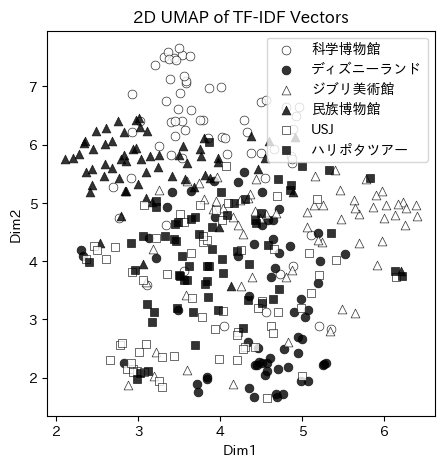

In [9]:
import seaborn as sns

# 可視化
plt.figure(figsize=(5, 5))

combinations = [
     {"color": "white", "marker": "o"},
     {"color": "black", "marker": "o"},
     {"color": "white", "marker": "^"},
     {"color": "black", "marker": "^"},
     {"color": "white", "marker": "s"},
     {"color": "black", "marker": "s"},
]
combinations = {k: v for k,v in zip(set(y), combinations)}
print(combinations)

for label, combo in combinations.items():
    subset = df_umap[df_umap['label'] == label]
    sns.scatterplot(x='Dim1', y='Dim2', color=combo["color"], marker=combo["marker"], data=subset, s=40, edgecolor='black', alpha=0.8, label=label)

plt.title('2D UMAP of TF-IDF Vectors')
plt.legend(loc="upper right", bbox_to_anchor=(1.0, 1.0))
plt.savefig('umap_plot.pdf', bbox_inches='tight')
plt.show()

## ロジスティック回帰

- 分類
- ベータの可視化

In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from plotnine import *

# ジブリ美術館とハリポタツアーのインデックスを取得
y = np.array(y)
# ラベルの更新
y_updated = np.zeros_like(y)

positive_labels = ['科学博物館', '民族博物館']
negative_labels = ['ディズニーランド', 'USJ']

for idx, label in enumerate(y):
    if label in positive_labels:
        y_updated[idx] = 1
    elif label in negative_labels:
        y_updated[idx] = 0
    else:
        y_updated[idx] = -1

# テストデータの分割
mask_test = np.isin(y, ['ジブリ美術館', 'ハリポタツアー'])
mask_train = ~mask_test

X_train = X_tfidf[mask_train]
y_train = y_updated[mask_train]
X_test = X_tfidf[mask_test]
y_test = y_updated[mask_test]

In [11]:
# ロジスティック回帰モデルを学習
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# ベータの値を取得
coefs = clf.coef_[0]
features = vectorizer.get_feature_names_out()

In [12]:
# ベータの値と特徴名を結合してデータフレームを作成
df_coefs = pd.DataFrame({
    'feature': features,
    'coef': coefs
})

stop_words = "と て の 。 、 ！ あり けど 7 「 」 まし た ある な".split()
df_coefs.query("feature not in @stop_words", inplace=True)

<Figure size 300x600 with 0 Axes>

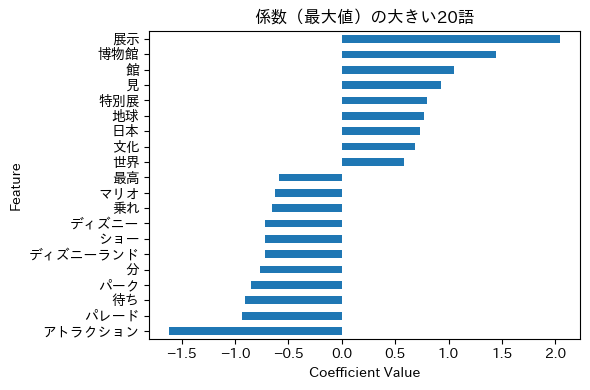

In [13]:
# 絶対値を基に上位の特徴を選択
top_n = 20
df_coefs["abs_coef"] = df_coefs["coef"].abs()
df_top_features = df_coefs.nlargest(top_n, 'abs_coef').drop(columns=["abs_coef"])

# プロット
plt.figure(figsize=(3, 6))
df_top_features.sort_values(by="coef").plot.barh(x='feature', y='coef', legend=False, figsize=(6, 4))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'係数（最大値）の大きい{top_n}語')
plt.tight_layout()
plt.show()

## 博物館と推論されたレビュー

In [14]:
# yが'ハリポタツアー'であるX_tfidfを取得
X_harrypotter = np.array(X)[y == 'ハリポタツアー']
X_tfidf_harrypotter = X_tfidf[y == 'ハリポタツアー']

# ロジスティック回帰モデルを使って推論
predicted_labels = clf.predict(X_tfidf_harrypotter)

# ラベルが1であるサンプルのインデックスを取得
positive_indices = np.where(predicted_labels == '1')[0]

# 元のXから該当するサンプルを取得
X_positive_samples = X_harrypotter[positive_indices]

In [15]:
import textwrap

for sample in X_positive_samples:
    wrapped_text = textwrap.fill(sample, width=40)
    print(wrapped_text, "\n")

店舗情報↓-----------------------------------
-----------【店名】バックロットカフェ※ワーナーブラザーススタジオツア
ー東京内【営業時間】9:30〜21:00頃(スタジオクローズまで)定休日：不定休
(ワーナーブラザーススタジオツアー東京に準ずる)【アクセス】西武豊島線
豊島園駅より徒歩3分都営地下鉄大江戸線 豊島園駅より徒歩5分【予算】4,000〜
5,000円/人(ディナー)【オススメ利用シーン】デート・家族/友人との利用【食
べログ評価(訪問日時点)】⭐️ニューオープンのためなし-------------
---------------------------------☆オススメポイ
ント☆①あのハリーポッター作品をイメージしたドリンク・フードが揃う②ヘドウィグを
形取ったビジュアルケーキ【メニュー】「グリフィンドールプレート(3,200円)」
「ヘドウィグケーキ(1,500円)」「バタービール(1,100円)」まずはメイン
料理として注文した、「グリフィンドールプレート」。プレートの主役はイギリスらしい
ローストビーフで、非常に大きく食べ応えのあるもの。サイズだけならステーキとも遜色
ない。ただ質に関してやはり専門店などには劣るかと。ソースも一般的な業務用のような
ものなので、特筆する点はない。ただ、このソースをセットのダッチパンケーキ風に付け
て食べるのは美味しいのでオススメ。ちなみにこの他にも各寮のプレートがあるので、自
分の推しの寮のプレートを注文してみて欲しい。続いてデザートとして注文可能なヘドウ
ィグケーキ。見た目がなんとも可愛いこちらのケーキは、ハリーポッターが飼っているフ
クロウのヘドウィグを形取ったケーキで、器も鳥籠を模しており、まさに映える一品。た
っぷりのクリームの中には、スポンジケーキやいちご、バナナといったフルーツも入って
いる。大きくボリュームあるケーキであった。そしてハリーポッター定番ドリンクのバタ
ービール。上の泡はキャラメルポップコーンのようなバターが効いた味わいで、ドリンク
部分は甘い炭酸飲料。大人から子供まで楽しめる味わいではあるが、やや甘すぎるので、
大人には少々しんどさもあるかと。ちなみにドリンクが入っていた特製ジョッキは洗って
お土産として持ち帰ることも可能である。【ま

In [16]:
np.mean(predicted_labels.astype(int))

0.21875

## 好きな文を分類してみよう

In [17]:
X_new = [
    "アイヌの文化の展示を見ました。また、手話を言語としてみなす展示も新しい発見が多くありました。",
    "ジェットコースター楽しかった！",
    """12月にジュエルミネーションを観たくて初めて行きました。土曜日で混んでたこともあり、駐車場は少し離れた場所になりましたが、入場口近くまで無料のシャトルバスが出ていました。
    アフターパスで夕方から入ったのもあり、園内広いので全然回りきれませんでしたが、ジュエルミネーションはとても綺麗だったし、乗り物も大人が乗っても楽しめるものも多くて良かったです☆
    あと、授乳室が２ヶ所にあるのも助かりました。
    ジュエリー・タワーに上れるの知らなかったので、次回はそちらに上って、ジュエリー・クリスタルの全景を観てみたいです。
    冬場はとにかく寒いのでしっかり防寒して行くと良いと思います。""", # よみうりランド
    "",  # 好きな文を分類できます。1は博物館の判定です。
    ]
X_new_tfidf = vectorizer.transform(X_new)
clf.predict(X_new_tfidf)

array(['1', '0', '0', '0'], dtype='<U8')

## 補足: 交差検証

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルのインスタンスを作成
clf = LogisticRegression(max_iter=1000)

# 5分割交差検証で予測を行う
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)

# 精度を計算
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9453


In [19]:
# 混同行列を計算
cm = confusion_matrix(y_train, y_pred)

# 混同行列を表示
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[122   6]
 [  8 120]]


## おまけ：確率の計算

各カテゴリーで特徴的な語の抽出

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


['科学博物館' '民族博物館' 'ハリポタツアー' 'ハリポタツアー' 'ハリポタツアー']


Processing words: 100%|██████████| 6336/6336 [01:19<00:00, 79.25it/s] 


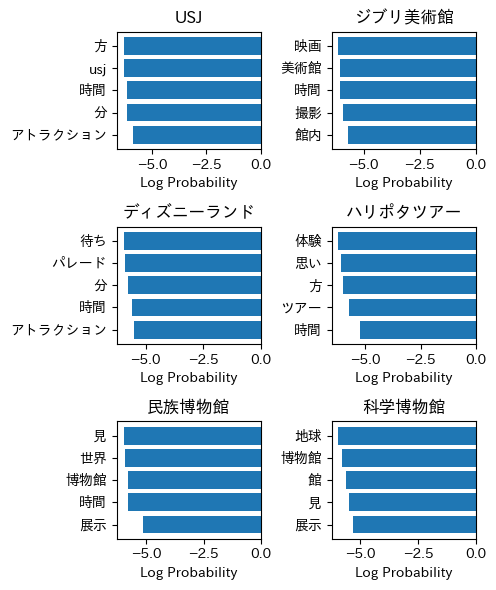

In [20]:
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=tokenize)

X_vec = vectorizer.fit_transform(X)

classifier = MultinomialNB()
classifier.fit(X_vec, y)
new_X = [
    "深海の圧力",
    "世界の文化と言語を学べた",
    "カエルのチョコレートおいしい",
    "魔法を学べた",
    "魔法を楽しめた",
]
print(classifier.predict(vectorizer.transform(new_X)))

# モデルから特徴の尤度を取得
# feature_log_prob_ndarray of shape (n_classes, n_features)
# Empirical log probability of features given a class, P(x_i|y).
log_prob = classifier.feature_log_prob_

# 特徴名の取得
feature_names = vectorizer.get_feature_names_out()

# データフレームを作成
df = pd.DataFrame(log_prob.T, columns=classifier.classes_, index=feature_names)

import spacy

# GiNZAのモデルをロード
nlp = spacy.load('ja_ginza')

# 全ての特徴名に対して品詞情報を取得し、内容語のみをリストに保持
content_words = []

# for word in feature_names:
for word in tqdm(feature_names, desc="Processing words"):
    doc = nlp(word)
    if len(doc) == 1 and doc[0].pos_ in ['NOUN', 'VERB', 'ADJ']:  # 名詞、動詞、形容詞のみを対象とする
        content_words.append(word)

# 特定の非内容語のリスト
specific_remove_words = ["ある", "ない", "こと", "い", "お", "あり", "いる"]

# 全ての非内容語をリストに格納
remove_words = [word for word in feature_names if word not in content_words] + specific_remove_words

# データフレームから非内容語を除外
df = df.drop(index=remove_words, errors='ignore')

import numpy as np
import matplotlib.pyplot as plt

# 各カテゴリで上位5の特徴を取得
top_n = 5
dfs = []

for column in df.columns:
    top_features = df[column].nlargest(top_n)
    top_features = top_features.reset_index()
    top_features.columns = ["Feature", "Log Probability"]
    top_features["Category"] = column
    dfs.append(top_features)

final_df = pd.concat(dfs, axis=0)

# ユニークなカテゴリ数を取得
n_categories = len(final_df['Category'].unique())

# サブプロットの作成
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 1 * n_categories))
flat_axes = axes.ravel()

for ax, category in zip(flat_axes, final_df['Category'].unique()):
    subset = final_df[final_df['Category'] == category]
    ax.barh(subset['Feature'], subset['Log Probability'], label=category)
    ax.set_title(category)
    ax.set_xlabel('Log Probability')

plt.tight_layout()
plt.show()